In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn-muted')
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## What about binning ?

The objective is to understand in wich case binning a continious feature can be benefict and compare the results from Neural Network vs Logistic regression.  
The experiment consist in predicted a binary target build with a non linear function. We are going to test a Neural Network and a Logistic regression with and without binning and analyse the results.

### Prep data

We simulate a dataset wich fit the objective

In [2]:
f = lambda x: x**3 - 7*x**2 + 4
x = np.arange(-4,9,.1)
y = f(x)
y = y + np.random.normal(0, 20, len(x))
target = (y > -20)*1

# Binning + one hot
to_str = lambda x: str(x) + '_'
x_bin = np.array(map(to_str, np.digitize(x, bins=np.arange(-4,9,2))))
enc = OneHotEncoder(sparse=False)
enc.fit(x_bin.reshape(-1, 1))
x_one_hot = enc.transform(x_bin.reshape(-1, 1))

data = pd.DataFrame({'x': x, 'x_bin': x_bin, 'y': y, 'target': target})

### Plot data

#### No binning

We want to explain the target (0 or 1) with a continious feature (X) from -4 to 9

Text(0.5,1,'No linear function to explain with continious feature')

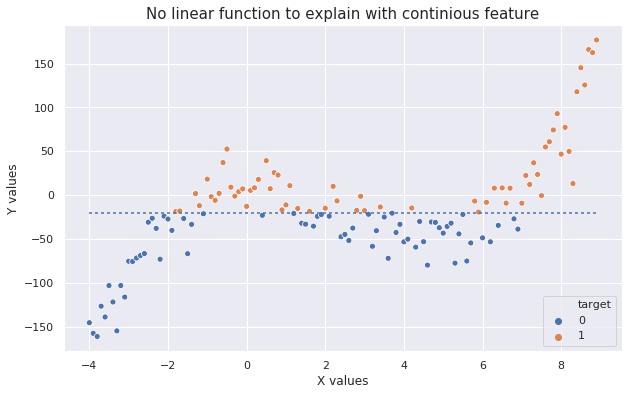

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="x", y="y", hue="target", data=data)
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend(loc="lower right")
plt.title('No linear function to explain with continious feature', fontsize=15)

#### With binning

In this case X is binning in buckets of length 2

Text(0.5,1,'No linear function to explain with binning feature')

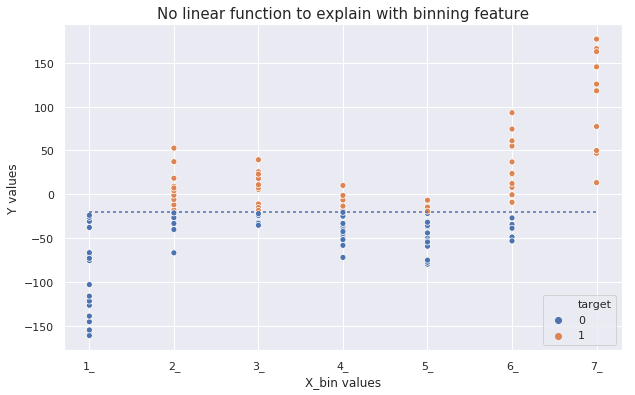

In [4]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="x_bin", y="y", hue="target", data=data)
plt.plot(data.x_bin, np.ones(len(data.x))*-20, dashes=[2,2])
plt.xlabel('X_bin values')
plt.ylabel('Y values')
plt.legend(loc="lower right")
plt.title('No linear function to explain with binning feature', fontsize=15)

### Fit Logistic regression and MLP

We build the response from a Neural Network and a Logistic regression

In [5]:
def custom_fit(x, y, model_type, one_hot=False):
    if model_type == 'RegLog':
        model = LogisticRegression()
    elif model_type == 'NN':
        model = MLPClassifier(hidden_layer_sizes=(30,20), random_state=42)
    if one_hot:
        to_str = lambda x: str(x) + '_'
        x_bin = np.array(map(to_str, np.digitize(x, bins=np.arange(-4,9,2))))
        enc = OneHotEncoder(sparse=False)
        enc.fit(x_bin.reshape(-1, 1))
        x = enc.transform(x_bin.reshape(-1, 1))
    else:
        x = x.reshape(-1, 1)
        enc = None
    model.fit(x, y.reshape(-1, 1))
    return model, enc

def custom_predict(model, x, enc=None):
    if enc:
        to_str = lambda x: str(x) + '_'
        x_bin = np.array(map(to_str, np.digitize(x, bins=np.arange(-4,9,2))))
        x = enc.transform(x_bin.reshape(-1, 1))
    else:
        x = x.reshape(-1, 1)
    probas = model.predict_proba(x)[:,1]
    return probas

RegLog, _ = custom_fit(data.x, data.target, 'RegLog', one_hot=False)
data['proba_reglog'] = custom_predict(RegLog, data.x)
RegLog_binning, enc_RegLog = custom_fit(data.x, data.target, 'RegLog', one_hot=True)
data['proba_reglog_binning'] = custom_predict(RegLog_binning, data.x, enc=enc_RegLog)
NN, _ = custom_fit(data.x, data.target, 'NN', one_hot=False)
data['proba_NN'] = custom_predict(NN, data.x)
NN_binning, enc_NN = custom_fit(data.x, data.target, 'NN', one_hot=True)
data['proba_NN_binning'] = custom_predict(NN_binning, data.x, enc=enc_NN)

data['pred_reglog'] = (data['proba_reglog']>0.5)*1
data['pred_reglog_binning'] = (data['proba_reglog_binning']>0.5)*1
data['pred_NN'] = (data['proba_NN']>0.5)*1
data['pred_NN_binning'] = (data['proba_NN_binning']>0.5)*1

### Plot results

#### Without binning

This is the output of both models:  
- Scores on the left  
- Binary responses on the right

In [6]:
def plot_decision_function(model, x, y, enc=None, h=0.02):
    x_min, x_max = data.x.min() - .5, data.x.max() + .5
    y_min, y_max = data.y.min() - .5, data.y.max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = custom_predict(model, np.c_[xx.ravel()], enc=enc)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=.2)

Text(0.5,1,'Prediction targets of NeuralNetwork')

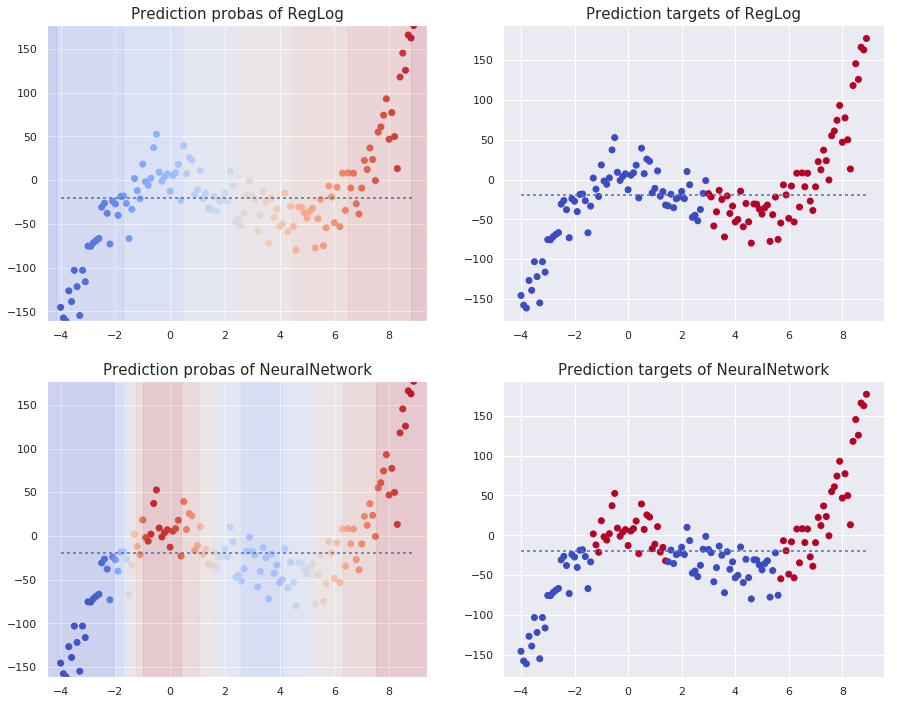

In [7]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.scatter(x, data.y, c=data.proba_reglog, label='Target', cmap='coolwarm')
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
plot_decision_function(RegLog, data.x, data.y)
plt.title('Prediction probas of RegLog', fontsize=15)

plt.subplot(222)
plt.scatter(x, data.y, c=data.pred_reglog, label='Target', cmap='coolwarm')
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
plt.title('Prediction targets of RegLog', fontsize=15)

plt.subplot(223)
plt.scatter(x, data.y, c=data.proba_NN, label='Target', cmap='coolwarm')
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
plot_decision_function(NN, data.x, data.y)
plt.title('Prediction probas of NeuralNetwork', fontsize=15)

plt.subplot(224)
plt.scatter(x, data.y, c=data.pred_NN, label='Target', cmap='coolwarm')
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
plt.title('Prediction targets of NeuralNetwork', fontsize=15)

Logistic regression fails to learn the non-linear part of the output, while the neural network succeeds

#### With binning

Binning is a way around the problem of non-linearity for logistic regression

Text(0.5,1,'Prediction targets of NeuralNetwork')

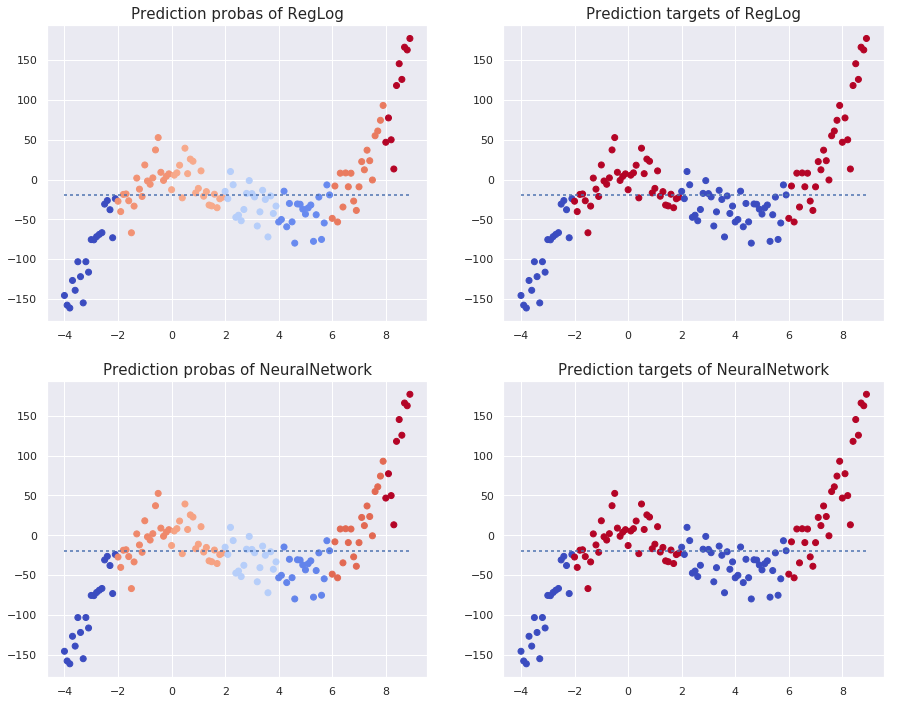

In [8]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.scatter(x, data.y, c=data.proba_reglog_binning, label='Target', cmap='coolwarm')
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
#plot_decision_function(RegLog_binning, data.x, data.y, enc=enc_RegLog)
plt.title('Prediction probas of RegLog', fontsize=15)

plt.subplot(222)
plt.scatter(x, data.y, c=data.pred_reglog_binning, label='Target', cmap='coolwarm')
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
plt.title('Prediction targets of RegLog', fontsize=15)

plt.subplot(223)
plt.scatter(x, data.y, c=data.proba_NN_binning, label='Target', cmap='coolwarm')
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
#plot_decision_function(NN_binning, data.x, data.y, enc=enc_RegLog)
plt.title('Prediction probas of NeuralNetwork', fontsize=15)

plt.subplot(224)
plt.scatter(x, data.y, c=data.pred_NN_binning, label='Target', cmap='coolwarm')
plt.plot(data.x, np.ones(len(data.x))*-20, dashes=[2,2])
plt.title('Prediction targets of NeuralNetwork', fontsize=15)

#### ROC Curve

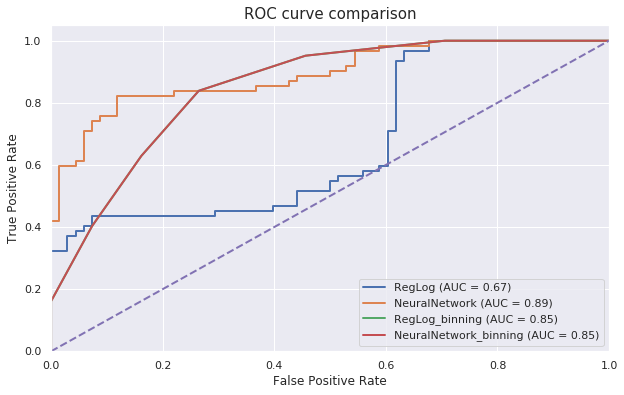

In [9]:
fpr_RegLog, tpr_RegLog, _ = roc_curve(data.target, data.proba_reglog)
roc_auc_RegLog = auc(fpr_RegLog, tpr_RegLog)
fpr_NN, tpr_NN, _ = roc_curve(data.target, data.proba_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)
fpr_RegLog_binning, tpr_RegLog_binning, _ = roc_curve(data.target, data.proba_reglog_binning)
roc_auc_RegLog_binning = auc(fpr_RegLog_binning, tpr_RegLog_binning)
fpr_NN_binning, tpr_NN_binning, _ = roc_curve(data.target, data.proba_NN_binning)
roc_auc_NN_binning = auc(fpr_NN_binning, tpr_NN_binning)

plt.figure(figsize=(10, 6))
lw = 2
plt.plot(fpr_RegLog, tpr_RegLog,
         lw=lw, label='RegLog (AUC = %0.2f)' % roc_auc_RegLog)
plt.plot(fpr_NN, tpr_NN,
         lw=lw, label='NeuralNetwork (AUC = %0.2f)' % roc_auc_NN)
plt.plot(fpr_RegLog_binning, tpr_RegLog_binning,
         lw=lw, label='RegLog_binning (AUC = %0.2f)' % roc_auc_RegLog_binning)
plt.plot(fpr_NN_binning, tpr_NN_binning,
         lw=lw, label='NeuralNetwork_binning (AUC = %0.2f)' % roc_auc_NN_binning)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve comparison', fontsize=15)
plt.legend(loc="lower right")
plt.show()

To conclude, linear regression fails to solve non-linear problems while neural networks permit. Binning a feature helps to manage the non-linearity problem for logistic regression, however, we loose information for the neural network. The best solution for this kind of problem is to use a neural network using the continious feature

## How to fill na ?

The objective is to show the influence of the fillna method in the result of a model and compare the results of a Neural Network and a Logistic Regression for different types of methods

### Fillna -1

In this exemple we replace the nan's by -1

#### Prep data

In [10]:
x_size = 1000
nb_nan = 600
x = np.random.choice(np.arange(20,80, dtype='float'), x_size)
mask=np.zeros(x_size,dtype=bool)
mask[:nb_nan] = True
np.random.shuffle(mask)
x[mask] = np.nan

create_target = lambda x: 2*x + 10
y = create_target(x)
y[np.isnan(y)] = pd.Series(y).max()
y = y + np.random.normal(0, 20, x_size)
target = (y>(pd.Series(y).mean()))*1

data = pd.DataFrame({'x': x, 'y': y, 'target': target})
data['x_fill_na'] = data.x.fillna(-1)

#### Plot data

We try to explain this binary problem with Neural Network and Logistic Regression. X contains 60% of nan and we try to use the feature to predict the target.

Text(0.5,1,'Function to explain with continious feature')

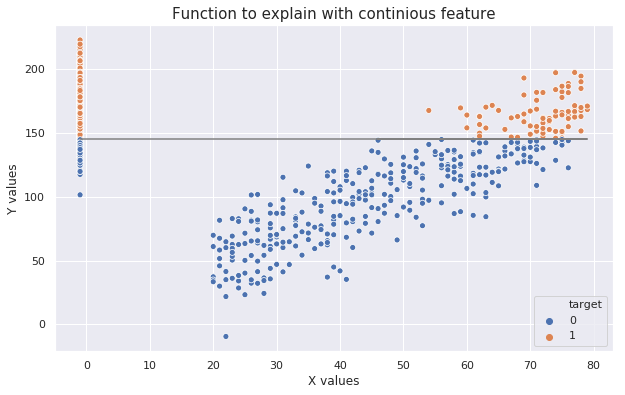

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="x_fill_na", y="y", hue="target", data=data)
plt.plot(data['x_fill_na'], np.ones(len(data['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend(loc="lower right")
plt.title('Function to explain with continious feature', fontsize=15)

#### Fit Models

In [12]:
def predict_RegLog(x, y, one_hot=False):  
    RegLog = LogisticRegression()
    if not one_hot:
        x = x.reshape(-1, 1)
    RegLog.fit(x, y.reshape(-1, 1))
    pred_reglog = RegLog.predict(x)
    proba_reglog = RegLog.predict_proba(x)[:,1]
    return proba_reglog

def predict_NN(x, y, one_hot=False):  
    NN = MLPClassifier(hidden_layer_sizes=(30,20,20,20), random_state=42)
    if not one_hot:
        x = x.reshape(-1, 1)
    NN.fit(x, y.reshape(-1, 1))
    pred_NN = NN.predict(x)
    proba_NN = NN.predict_proba(x)[:,1]
    return proba_NN

data['proba_reglog'] = predict_RegLog(data['x_fill_na'], data.target, one_hot=False)
data['proba_NN'] = predict_NN(data['x_fill_na'], data.target, one_hot=False)

data['pred_reglog'] = (data['proba_reglog']>0.5)*1
data['pred_NN'] = (data['proba_NN']>0.5)*1

#### Plot results

Text(0.5,1,'Prediction targets of NeuralNetwork')

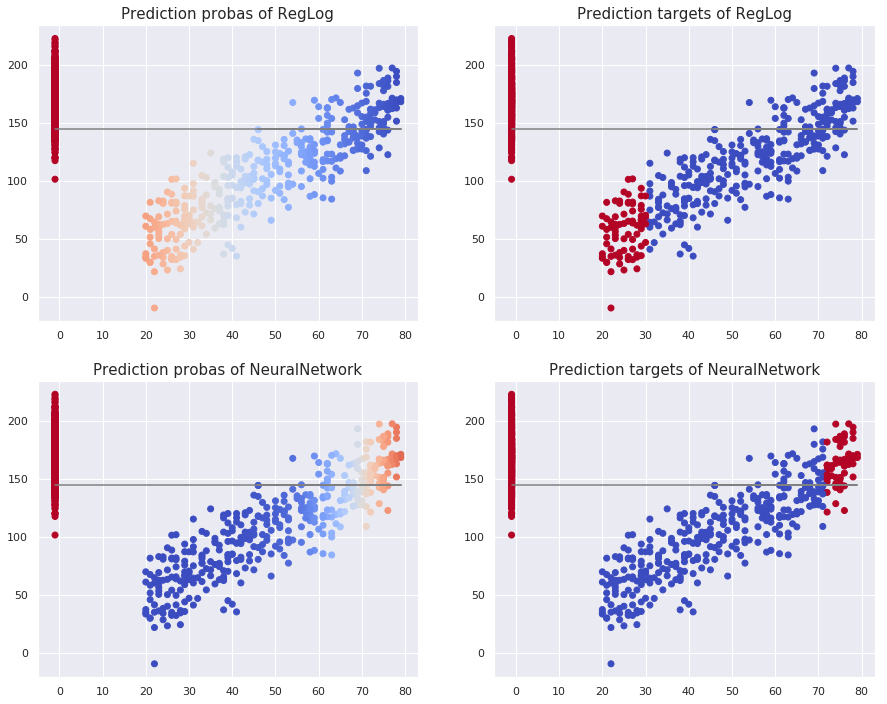

In [13]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.scatter(data['x_fill_na'], data.y, c=data.proba_reglog, label='Target', cmap='coolwarm')
plt.plot(data['x_fill_na'], np.ones(len(data['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.title('Prediction probas of RegLog', fontsize=15)

plt.subplot(222)
plt.scatter(data['x_fill_na'], data.y, c=data.pred_reglog, label='Target', cmap='coolwarm')
plt.plot(data['x_fill_na'], np.ones(len(data['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.title('Prediction targets of RegLog', fontsize=15)

plt.subplot(223)
plt.scatter(data['x_fill_na'], data.y, c=data.proba_NN, label='Target', cmap='coolwarm')
plt.plot(data['x_fill_na'], np.ones(len(data['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.title('Prediction probas of NeuralNetwork', fontsize=15)

plt.subplot(224)
plt.scatter(data['x_fill_na'], data.y, c=data.pred_NN, label='Target', cmap='coolwarm')
plt.plot(data['x_fill_na'], np.ones(len(data['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.title('Prediction targets of NeuralNetwork', fontsize=15)

The concentration of observations in -1 completely biases the results of the logistic regression while the neural network manages to learn correctly

### Fillna median

We apply the same process with a median fillna method

#### Prep data

In [14]:
x_size = 1000
nb_nan = 600
x = np.random.choice(np.arange(20,80, dtype='float'), x_size)
mask=np.zeros(x_size,dtype=bool)
mask[:nb_nan] = True
np.random.shuffle(mask)
x[mask] = np.nan

create_target = lambda x: 2*x + 10
y = create_target(x)
y[np.isnan(y)] = pd.Series(y).max()
y = y + np.random.normal(0, 20, x_size)
target = (y>(pd.Series(y).mean()))*1

data_median = pd.DataFrame({'x': x, 'y': y, 'target': target})
data_median['x_fill_na'] = data_median.x.fillna(data_median.x.median())

#### Plot data_median

Text(0.5,1,'Function to explain with continious feature')

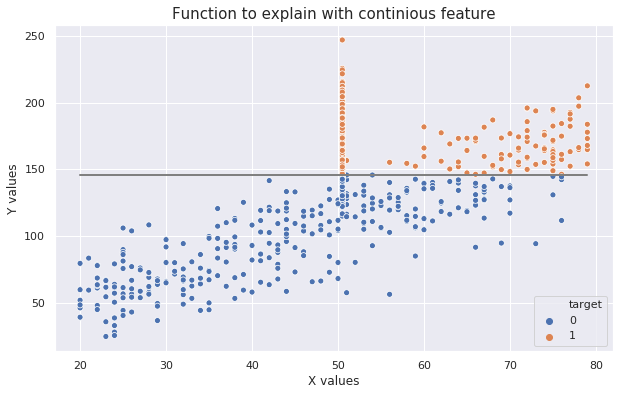

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="x_fill_na", y="y", hue="target", data=data_median)
plt.plot(data_median['x_fill_na'], np.ones(len(data_median['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.legend(loc="lower right")
plt.title('Function to explain with continious feature', fontsize=15)

#### Fit Models

In [16]:
def predict_RegLog(x, y, one_hot=False):  
    RegLog = LogisticRegression()
    if not one_hot:
        x = x.reshape(-1, 1)
    RegLog.fit(x, y.reshape(-1, 1))
    pred_reglog = RegLog.predict(x)
    proba_reglog = RegLog.predict_proba(x)[:,1]
    return proba_reglog

def predict_NN(x, y, one_hot=False):  
    NN = MLPClassifier(hidden_layer_sizes=(30,20,20,20), random_state=42)
    if not one_hot:
        x = x.reshape(-1, 1)
    NN.fit(x, y.reshape(-1, 1))
    pred_NN = NN.predict(x)
    proba_NN = NN.predict_proba(x)[:,1]
    return proba_NN

data_median['proba_reglog'] = predict_RegLog(data_median['x_fill_na'], data_median.target, one_hot=False)
data_median['proba_NN'] = predict_NN(data_median['x_fill_na'], data_median.target, one_hot=False)

data_median['pred_reglog'] = (data_median['proba_reglog']>0.5)*1
data_median['pred_NN'] = (data_median['proba_NN']>0.5)*1

#### Plot results

Text(0.5,1,'Prediction targets of NeuralNetwork')

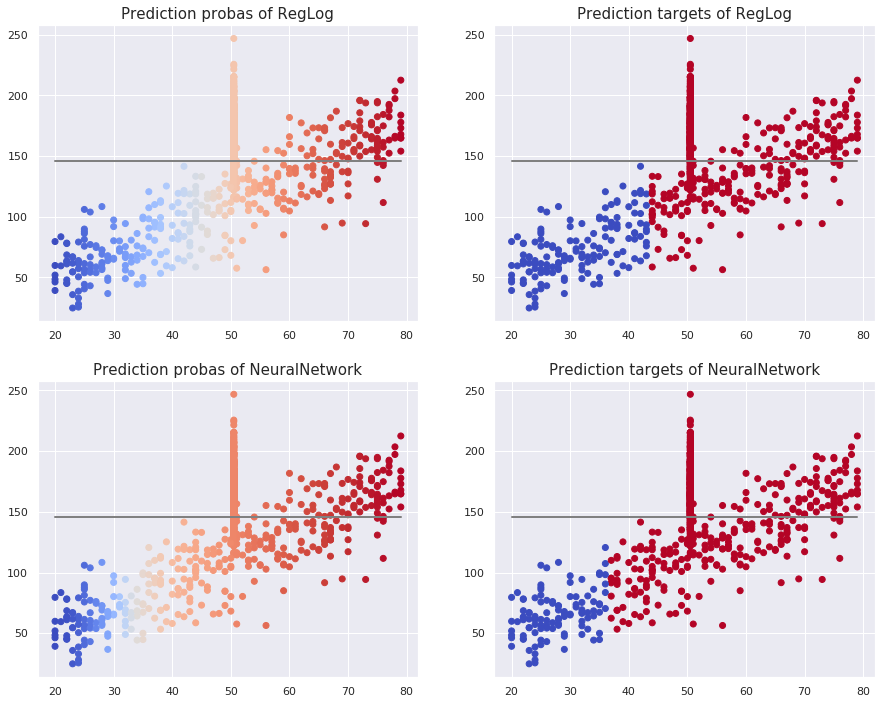

In [17]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.scatter(data_median['x_fill_na'], data_median.y, c=data_median.proba_reglog, label='Target', cmap='coolwarm')
plt.plot(data_median['x_fill_na'], np.ones(len(data_median['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.title('Prediction probas of RegLog', fontsize=15)

plt.subplot(222)
plt.scatter(data_median['x_fill_na'], data_median.y, c=data_median.pred_reglog, label='Target', cmap='coolwarm')
plt.plot(data_median['x_fill_na'], np.ones(len(data_median['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.title('Prediction targets of RegLog', fontsize=15)

plt.subplot(223)
plt.scatter(data_median['x_fill_na'], data_median.y, c=data_median.proba_NN, label='Target', cmap='coolwarm')
plt.plot(data_median['x_fill_na'], np.ones(len(data_median['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.title('Prediction probas of NeuralNetwork', fontsize=15)

plt.subplot(224)
plt.scatter(data_median['x_fill_na'], data_median.y, c=data_median.pred_NN, label='Target', cmap='coolwarm')
plt.plot(data_median['x_fill_na'], np.ones(len(data_median['x_fill_na']))*pd.Series(y).mean(), color='grey')
plt.title('Prediction targets of NeuralNetwork', fontsize=15)

The concentration of observations at the median level affects the results of both models and none succeed in learning correctly

### ROC Curves

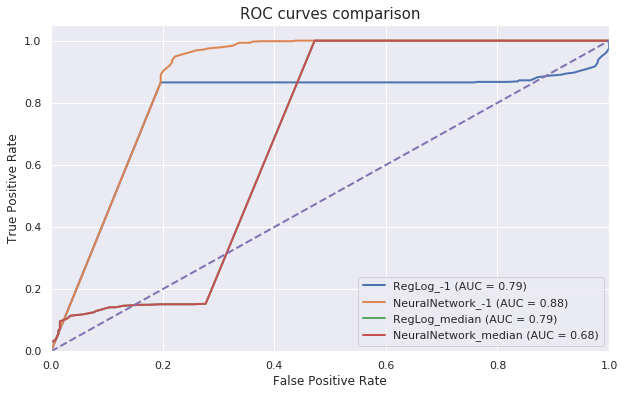

In [18]:
fpr_RegLog, tpr_RegLog, _ = roc_curve(data.target, data.proba_reglog)
roc_auc_RegLog = auc(fpr_RegLog, tpr_RegLog)
fpr_NN, tpr_NN, _ = roc_curve(data.target, data.proba_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)
fpr_RegLog_median, tpr_RegLog_median, _ = roc_curve(data_median.target, data_median.proba_reglog)
roc_auc_RegLog_median = auc(fpr_RegLog, tpr_RegLog)
fpr_NN_median, tpr_NN_median, _ = roc_curve(data_median.target, data_median.proba_NN)
roc_auc_NN_median = auc(fpr_NN_median, tpr_NN_median)

plt.figure(figsize=(10, 6))
lw = 2
plt.plot(fpr_RegLog, tpr_RegLog,
         lw=lw, label='RegLog_-1 (AUC = %0.2f)' % roc_auc_RegLog)
plt.plot(fpr_NN, tpr_NN,
         lw=lw, label='NeuralNetwork_-1 (AUC = %0.2f)' % roc_auc_NN)
plt.plot(fpr_RegLog_median, tpr_RegLog_median,
         lw=lw, label='RegLog_median (AUC = %0.2f)' % roc_auc_RegLog_median)
plt.plot(fpr_NN_median, tpr_NN_median,
         lw=lw, label='NeuralNetwork_median (AUC = %0.2f)' % roc_auc_NN_median)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves comparison', fontsize=15)
plt.legend(loc="lower right")
plt.show()

To conclude, the performances show that the best fillna method for this kind of problem is to put a very distinct value of the others for the neural network. However, in this case, no fillna method is satisfactory for the logistic regression. This example shows a significant advantage for neuron networks for their ability to handle missing values